<img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png" width="300" height="300" align="center"/><br>

Welcome to another JAX tutorial. I hope you all have been enjoying the JAX Tutorials so far. If you haven't gone through the previous tutorials, I highly suggest going through them. Here are the links:

1. [TF_JAX_Tutorials - Part 1](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part1)
2. [TF_JAX_Tutorials - Part 2](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part2)
3. [TF_JAX_Tutorials - Part 3](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part3)
4. [TF_JAX_Tutorials - Part 4 (JAX and DeviceArray)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-4-jax-and-devicearray)
5. [TF_JAX_Tutorials - Part 5 (Pure Functions in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-5-pure-functions-in-jax/)
6. [TF_JAX_Tutorials - Part 6 (PRNG in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-6-prng-in-jax/)
7. [TF_JAX_Tutorials - Part 7 (JIT in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-7-jit-in-jax)



People often ask me this: **If I know TensorFlow/Torch, why should I bother learning about JAX?**<br>
Although there are **n** reasons, I will present one of the concepts in JAX that would be enough to convince you to try it. Today, we will look into **`Auto Vectorization`**. We will talk about two transformations namely, **`vmap`** and **`pmap`**. Sit tight, you gonna experience something really cool today!

In [1]:
import os
import cv2
import glob
import time
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from jax import make_jaxpr
from jax.config import config
from jax import grad, vmap, pmap, jit



%config IPCompleter.use_jedi = False

In [2]:
# Reference: https://www.kaggle.com/narainp/jax-tpu-demo-wip
if 'TPU_NAME' in os.environ:
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
        config.FLAGS.jax_xla_backend = "tpu_driver"
        config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
        print('Registered TPU:', config.FLAGS.jax_backend_target)
        print("")
        print("TPU devices found:")
        for device in jax.devices():
            print(device)
else:
    print('No TPUs found!".')

Registered TPU: grpc://10.0.0.2:8470

TPU devices found:
TPU_0(host=0,(0,0,0,0))
TPU_1(host=0,(0,0,0,1))
TPU_2(host=0,(1,0,0,0))
TPU_3(host=0,(1,0,0,1))
TPU_4(host=0,(0,1,0,0))
TPU_5(host=0,(0,1,0,1))
TPU_6(host=0,(1,1,0,0))
TPU_7(host=0,(1,1,0,1))


# Introduction

Simply put Automatic Vectorization is a way of converting a process that operates on a single example to something that can operate on a vector. Let's take a very basic example to understand this. 

Lets' say you have two arrays: <br>

Array 1 => 1 2 3 4 5 <br>
Array 2 => 10 20 30 40 50<br>

You want to perform elementwise `addition` operation on these two arrays. One way to do this is using a loop like this<br>
```python
result = []
for i in range(5):
    res.append(array_1[i] + array_2[i])
```

Although this is right, this is doing one operation at a time. The addition procedure is the same for all the elements. Hence a better way to perform all the elementwise additions in one go. For example, the way you do it in `numpy`<br>
```python
res = array_1 + array_2
```

I hope it gave you some sense of what auto-vectorization is. You can read about it in detail [here](https://www.coursera.org/lecture/parallelism-ia/2-2-vectorizing-your-code-VkFwo)

Before jumping to `vmap` transformation, we will take a few basic examples to demonstrate the need and ower of `vmap`. The first example focuses on the simple dot product of two vectors. Without any further due, let's jump in the code 

In [3]:
def dot_product(array1, array2):
    """Performs dot product on two jax arrays."""
    return jnp.dot(array1, array2)

In [4]:
def print_results(array1, array2, res, title=""):
    """Utility to print arrays and results"""
    if title:
        print(title)
        print("")
    print("First array => Shape: ", array1.shape)
    print(array1)
    print("")
    print("Second array => Shape: ", array2.shape)
    print(array2)
    print("")
    print("Results => Shape: ", res.shape)
    print(res)

## Dot product of two vectors

In [5]:
array1 =  jnp.array([1, 2, 3, 4])
array2 =  jnp.array([5, 6, 7, 8])
res = dot_product(array1, array2)

print_results(array1, array2, res, title="Dot product of two vectors")

Dot product of two vectors

First array => Shape:  (4,)
[1 2 3 4]

Second array => Shape:  (4,)
[5 6 7 8]

Results => Shape:  ()
70


## Dot product on a batch of vectors

If you have a batch of vectors, how would you perform the dot product for each pair of vectors in two arrays?
A few options are:
1. Using a loop: Loop over the batch size and perform dot product for each pair, store the result and return
2. Using vectorized operations like `einsum`, or
3. Using a combination of two or more vectorized operations like `elementwise product` followed by `elementwise` sum. Here `element` refers to a vector in a batch

Let's see these in action now

In [6]:
# What if we want to do this for a batch of vectors?
array1 = jnp.stack([jnp.array([1, 2, 3, 4]) for i in range(5)])
array2 = jnp.stack([jnp.array([5, 6, 7, 8]) for i in range(5)])

# First way to do batch vector product using loops
res1 = []
for i in range(5):
    res1.append(dot_product(array1[i], array2[i]))
res1 = jnp.stack(res1)

    
# In numpy, we can use `einsum` for the same
res2 = np.einsum('ij,ij-> i', array1, array2)

# We can even simplify einsum and chain two oprations to
# achieve the same
res3 = np.sum(array1*array2, axis=1)

# Let's check the results
print_results(array1,
              array2,
              res1,
              title="1. Dot product on a batch of vectors using loop")
print("="*70, "\n")
print_results(array1,
              array2,
              res2,
              title="2. Dot product on a batch of vectors in numpy using einsum")
print("="*70, "\n")
print_results(array1,
              array2,
              res3,
              title="3. Dot product on a batch of vectors using elementwise multiplication and sum")

1. Dot product on a batch of vectors using loop

First array => Shape:  (5, 4)
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

Second array => Shape:  (5, 4)
[[5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]

Results => Shape:  (5,)
[70 70 70 70 70]

2. Dot product on a batch of vectors in numpy using einsum

First array => Shape:  (5, 4)
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

Second array => Shape:  (5, 4)
[[5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]

Results => Shape:  (5,)
[70 70 70 70 70]

3. Dot product on a batch of vectors using elementwise multiplication and sum

First array => Shape:  (5, 4)
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

Second array => Shape:  (5, 4)
[[5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]

Results => Shape:  (5,)
[70 70 70 70 70]


# Introduction to `vmap`

In the above example, you can use the last two operations in JAX as well but we will take a look into a transformation that is literally the best of all. As I said earlier also, this is one of my favorite transformations in JAX - `vmap`

## What is `vmap`?
`vmap` is just another transformation like jit. It takes a function as an input along with the dimensions for the inputs and the outputs where the functions is to be mapped over to create a vectorized function. The syntax of `vmap` is like this: `vmap(function, in_axes, out_axes, ...)`

Here `function` is the function that you want to vectorize. `in_axes` is the axis indices that represent the batch dimension in the inputs to the original function. Similarly, `out_axes` are the axis indices that represent the batch dimension in the output. I highly suggest going through the [vmap documentation](https://jax.readthedocs.io/en/latest/jax.html#jax.vmap)

**Pro-tip**: Read carefully about the `positional` and `keyword` arguments and their effects on `in_axes` and `out_axes`.

When you transform a function using `vmap`, it returns a function that is a vectorized version of the original function. Let's see it in action

In [7]:
# Transform the `dot_product` function defined above
# using the `vmap` transformation
batch_dot_product = vmap(dot_product, in_axes=(0, 0))

# What does the transformation return?
batch_dot_product

<function __main__.dot_product(array1, array2)>

Did you notice that? `batch_dot_product` is just another function, a transformed version of the original`dot_product`
function. And this is all that you need to do to get a version that runs in a vectorized fashion. Isn't that amazing?

Let's use the transformed version `batch_dot_product` now to do dot product for a batch of vectors efficiently.

In [8]:
# Using vmap transformed function
res4 = batch_dot_product(array1, array2)
print_results(array1,
              array2,
              res4,
              title="Dot product of a batch of vectors using vmap")

Dot product of a batch of vectors using vmap

First array => Shape:  (5, 4)
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]

Second array => Shape:  (5, 4)
[[5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]

Results => Shape:  (5,)
[70 70 70 70 70]


**Note:** Both the arguments necessarily do not need to have a batch dimension. For example, we can take one vector and perform the dot product with a batch of some vectors. For the input that doesn't have a batch dimension, you can just pass `None` in the `in_axes(..)` argument. Let's take an example to make it clear.

In [9]:
# A vector
array1 = jnp.array([1, 2, 3, 4])

# We have a batch of vectors as well already `array2` which looks like this
# [[5 6 7 8]
# [5 6 7 8]
# [5 6 7 8]
# [5 6 7 8]
# [5 6 7 8]]

# We will now perform the dot product of array1 (a single vetor) with a batch
# of vectors (array2 in this case). We will pass `None` in the `in_axes(..)` argument
# to say that the first input doesn't have a batch dimension

res5 = vmap(dot_product, in_axes=(None, 0))(array1, array2)
print_results(array1,
              array2,
              res5,
              title="Only one of the inputs in batched")

Only one of the inputs in batched

First array => Shape:  (4,)
[1 2 3 4]

Second array => Shape:  (5, 4)
[[5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]

Results => Shape:  (5,)
[70 70 70 70 70]


# Vmap and Jaxpr

Like JIT, you can take the `vmap` transformed function and inspect the corresponding jaxpr to get an idea of how the ops are executed. This is another cool thing about JAX. You can take any transformed function and insect the corresponding `jaxpr`. Let's do that for our `batch_dot_product` function

In [10]:
# Like JIT, you can inpsect the transformation using jaxprs
make_jaxpr(vmap(dot_product, in_axes=(None, 0)))(array1, array2)

{ lambda  ; a b.
  let c = dot_general[ dimension_numbers=(((0,), (1,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] a b
  in (c,) }

# Data Augmentation - Building a simple, fast, and scalable pipeline

What we did till now barely shows the real power of `vmap`. We will take a more complex op example to showcase how powerful and flexible `vmap` really is. This will also give you an idea of why using `vmap` and `pmap`(we will look into it later) feels like a **superpower**. 

Because I love images, we will build an image data augmentation pipeline purely in JAX. We will then scale it using `vmap` and `pmap`. We will do the following steps in this whole process:

1. Download a bunch of images from Google images
2. Read the images and possibly resize them to a fairly moderate size
3. We will build a pipeline to do augmentation on a single image
4. We will use the same pipeline to generate a bunch of augmentations for the same image
5. We will then use the same pipeline to do augmentation on a batch of images
6. We will then scale the same pipeline to do augmentation on a much bigger batch size on parallel devices (GPUs/TPUs)

## Step 1: Download a bunch of images

In [11]:
def download_images():
    urllib.request.urlretrieve("https://i.imgur.com/Bvro0YD.png", "elephant.png")
    urllib.request.urlretrieve("https://images-eu.ssl-images-amazon.com/images/I/A1WuED4KiRL.jpg", "cat.jpg")
    urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/1/18/Dog_Breeds.jpg", "dog.jpg")
    urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/1/1e/The_Korean_Lucky_Bird_%28182632069%29.jpeg", "bird.jpg")
    urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/e/ea/Vervet_Monkey_%28Chlorocebus_pygerythrus%29.jpg", "monkey.jpg")
    urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/f/fa/Puppy.JPG", "puppy.jpg")
    urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/2/2c/Lion-1.jpg", "lion.jpg")
    urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/4/41/Siberischer_tiger_de_edit02.jpg", "tiger.jpg")
    print("Downloading finished")
    
    
# Download the images
download_images()

## Step 2: Read and Resize

Although we can read and resize on the fly, we only have 8 images, so we will read and resize the images before augmenting them. Again, these two steps will/should be a part of your pipeline, we are just simplifying the example. We will use `(800, 800)` as the final size of the images

In [12]:
def read_images(size=(800, 800)):
    """Read jpg/png images from the disk.
    
    Args:
        size: Size to be used while resizing
    Returns:
        A JAX array of images
    """
    png_images = sorted(glob.glob("*.png"))
    jpg_images = sorted(glob.glob("*.jpg"))
    all_images = png_images + jpg_images
    
    images = []
    
    for img in all_images:
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        images.append(img)
        
    return jnp.array(images)


# Read and resize
images = read_images()
print("Total number of images: ", len(images))

Total number of images:  8


In [13]:
# Utility function for plotting the images
def plot_images(images, batch_size, num_cols=4, figsize=(15, 8), title="Images "):
    num_rows = batch_size // num_cols
    
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    for i, img in enumerate(images):
        ax[i // num_cols, i % num_cols].imshow(images[i])
        ax[i // num_cols, i % num_cols].axis("off")
        #ax[i // num_cols, i % num_cols].set_title(str(i+1))
        
    plt.tight_layout()
    plt.suptitle(title, x=0.5, y=1.0, fontsize=16)
    plt.show()

## Step 3: A very simple augmentation pipeline

We will start with a very basic and simple augmentation pipeline. We will use a single image as an input and the pipeline will return an augmented version of the image. The augmentation pipeline will either rotate the input image or keep it as it is depending on a boolean value where `0` means no rotating while `1` says to rotate the image by 90 degrees.

In [14]:
def rotate_img(img):
    return jnp.rot90(img, axes=(0, 1))

def identity(img):
    return img

def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degrees.
    
    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not
    Returns:
        Either Rotated or an identity image
    """
    
    return jax.lax.cond(rotate, rotate_img, identity, img)

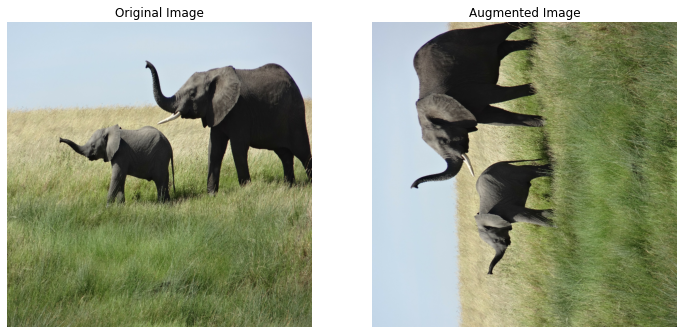

In [15]:
# Run the pipeline on a single image

# Get an image
img = images[0]
img_copy = img.copy()

# Pass the image copy to augmentation pipeline
augmented = random_rotate(img_copy, 1)

# Plot the original image and the augmented image
_, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original Image")

ax[1].imshow(augmented)
ax[1].axis("off")
ax[1].set_title("Augmented Image")

plt.show()

## Step 4: Generating multiple augmented images from a single image

We will now generate `n` images from the same pipeline using `vmap`. We will keep `n=8` to keep it simple. This is the point where you will start to realize how powerful `vmap` is. 

Number of images to generate:  8
Rotate-or-not array:  [1 1 0 1 0 1 0 0]


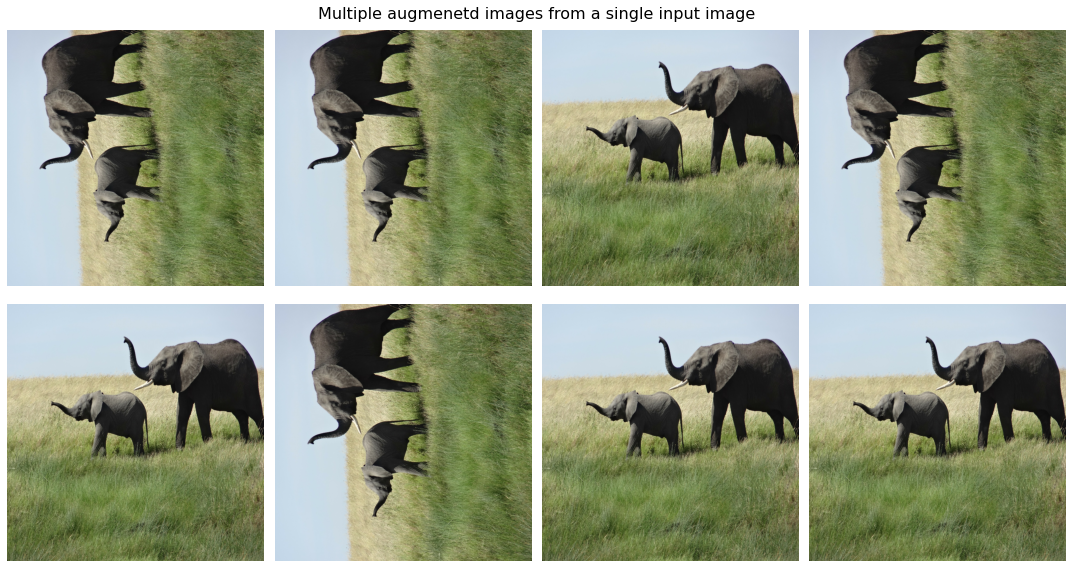

In [16]:
# Using the same original image
img_copy = img.copy()

# Batch size of the output as well as for the boolean array
# used to tell whether to rotate an input image or not
batch_size = 8

# We use seed for anything that involves `random`
key = random.PRNGKey(1234)

# Although splitting is not necessary as the key is only used once,
# I will just leave the original key as it is
key, subkey = random.split(key)
rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)

# Return identical or flipped image via augmentation pipeline
# We will transform the original `random_rotate(..)` function
# using vmap
augmented = vmap(random_rotate, in_axes=(None, 0))(img_copy, rotate)

print("Number of images to generate: ", batch_size)
print("Rotate-or-not array: ", rotate)
plot_images(augmented,
            batch_size=8,
            title="Multiple augmenetd images from a single input image"
           )

So, we just reused the same pipeline to generate multiple images that we wrote for augmenting a single image. At this point, you can say `Well, that's not very impressive. With a little more lines I could have done that without using vmap`. 

And if you are thinking in that direction, just hold tight! I am gonna change your perception by the end of the notebook

## Step 4: Using the same augmentation pipeline to augment a batch of images

In the previous step, we used one image to generate a bunch of augmented images in one go. It was similar to the example where we saw that one of the inputs to the vmapped function is a single example while the others are batched. Now we will reuse the same pipeline to augment a batch of input images i.e.

1. Provide a batch of input images to the pipeline
2. Augment the input batch
3. Get a batch of augmented images

We will now use all the `8` images we downloaded in the beginning as the input batch. Before we run the augmentation pipeline on these images, let's plot the original images once

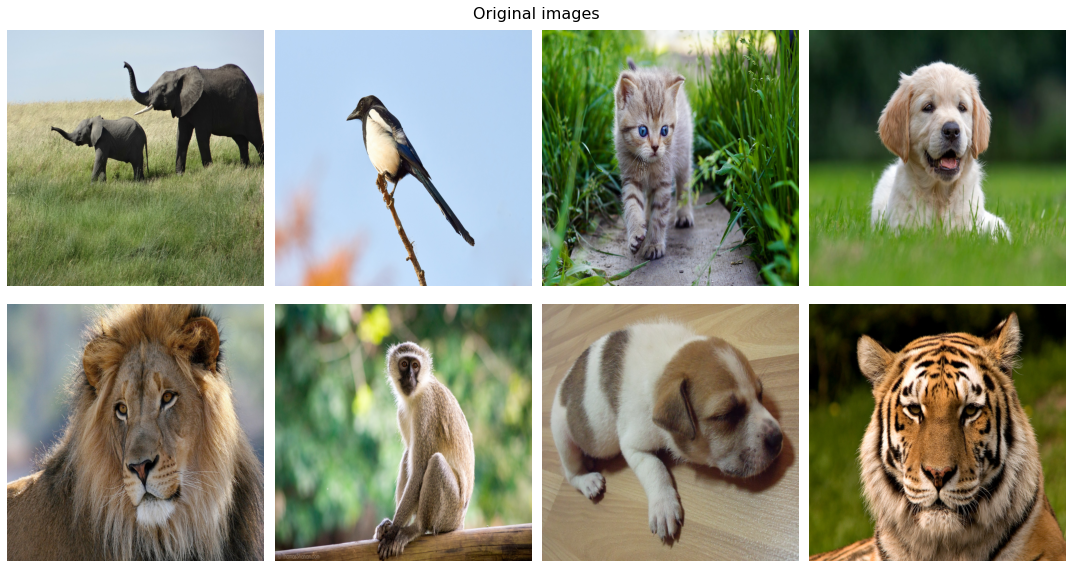

In [17]:
# Original images
plot_images(images, batch_size=8, title="Original images")

We will now augment this input batch of images. Look at the inputs to the `in_axes()` argument carefully

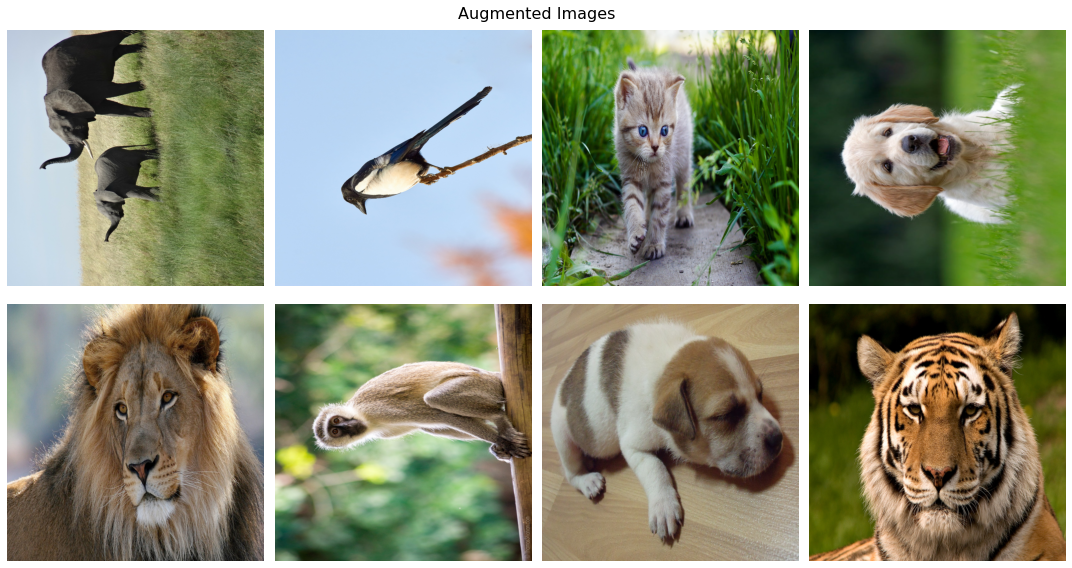

In [18]:
# Augment a batch of input images using the same augmentation pipeline
augmented = vmap(random_rotate, in_axes=(0, 0))(images, rotate)
plot_images(augmented, batch_size=8, title="Augmented Images")

Since `vmap` is just another transformation and we all know that JAX allows the composition of these transformations. To make this pipeline **even faster**, we can **`jit`** the `vmapped` function 😎😎😎

Not only we can jit it, we can inspect the **`jitted-vmapped`** function using `jaxprs`

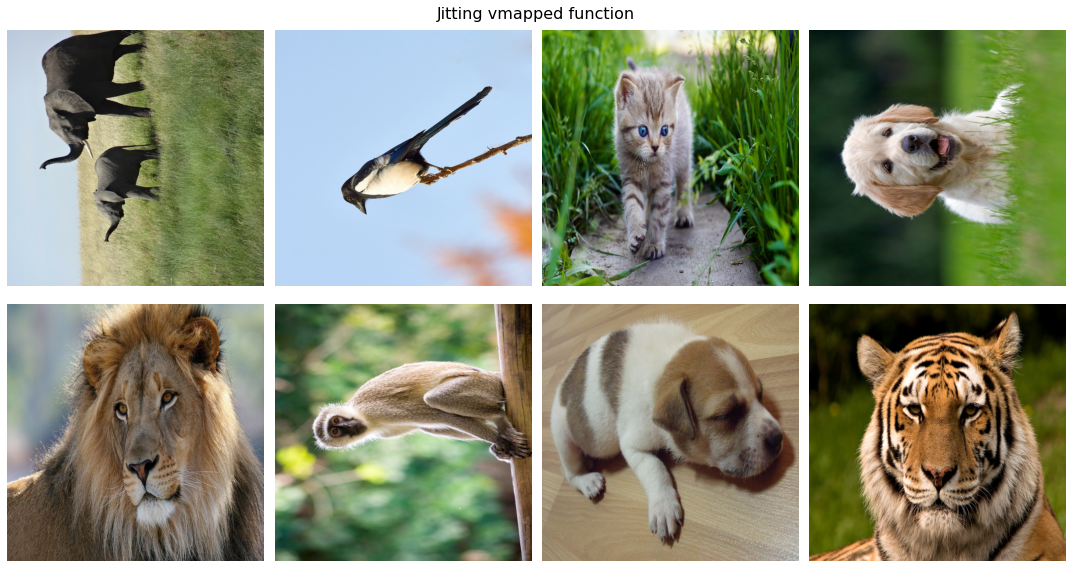

In [19]:
# JIT the vmapped function
vmap_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))

# Run the pipeline again using the jitted function
augmented = (vmap_jitted(images, rotate)).block_until_ready()

# Plot the images and check the results
plot_images(augmented, batch_size=8, title="Jitting vmapped function")

In [20]:
# Use jaxpr to see how the transformation ops are executed
make_jaxpr(jit(vmap(random_rotate, in_axes=(0, 0))))(images, rotate)

{ lambda  ; a b.
  let c = xla_call[ backend=None
                    call_jaxpr={ lambda  ; a b.
                                 let c = ne b 0
                                     d = convert_element_type[ new_dtype=int32
                                                               weak_type=False ] c
                                     e = eq d 0
                                     f = broadcast_in_dim[ broadcast_dimensions=(0,)
                                                           shape=(8, 800, 800, 3) ] e
                                     g = select f a a
                                     h = eq d 1
                                     i = broadcast_in_dim[ broadcast_dimensions=(0,)
                                                           shape=(8, 800, 800, 3) ] h
                                     j = select i a a
                                     k = rev[ dimensions=(2,) ] j
                                     l = transpose[ permutation=(0, 2, 1, 3) ] k

So, we saw that I can write a function that acts on a single image, and

1. Transform the same function to operate on batches using `vmap`
2. Can generate multiple augmented images from a single image
3. Can apply augmentation to different images in a batch
4. We can jit the entire vmap transformation
5. We can inspect the whole thing using jaxprs

<a href="https://emoji.gg/emoji/MindBlown"><img src="https://emoji.gg/assets/emoji/MindBlown.png" width="64px" height="64px" alt="MindBlown" align="center"></a>


This is not the end. I told you that by the end of the notebook I will convince you that `vmap` and `pmap` are a big deal. So, let's do something cool now

## Step 5: Fast and Scalable Data Augmentation Pipeline

We will add more augmentations to make it, even more, compute-heavy. You can define your augmentation as well if you like, I will stick to the simple augmentations for the time being. We will use three different augmentations namely,

1. Random Rotation by degrees
2. Random Horizontal Flip
3. Random Vertical Flip

In [21]:
def rotate_90(img):
    """Rotates an image by 90 degress k times."""
    return jnp.rot90(img, k=1, axes=(0, 1))


def identity(img):
    """Returns an image as it is."""
    return img


def flip_left_right(img):
    """Flips an image left/right direction."""
    return jnp.fliplr(img)


def flip_up_down(img):
    """Flips an image in up/down direction."""
    return jnp.flipud(img)


def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degrees.
    
    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not
    Returns:
        Rotated or an identity image
    """

    return jax.lax.cond(rotate, rotate_90, identity, img)


def random_horizontal_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_left_right, identity, img)
    
    
def random_vertical_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_up_down, identity, img)


# Get the jitted version of our augmentation functions
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))


def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_jitted(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_jitted(augmented, flip)
    
    return augmented.block_until_ready()

Call:  1 => Time taken to generate augmentations: 1.48
Call:  2 => Time taken to generate augmentations: 0.03
Call:  3 => Time taken to generate augmentations: 0.02


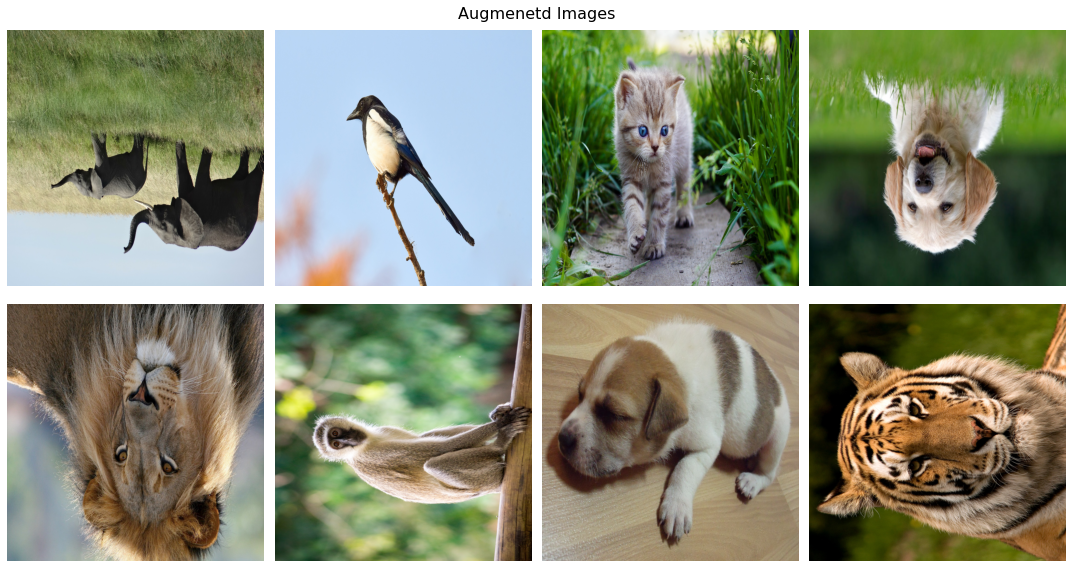

In [22]:
# Because we are jitting the transformations, we will record the
# time taken for augmentation on subsequent calls

for i in range(3):
    print("Call: ", i + 1, end=" => ")
    key=random.PRNGKey(0)
    start_time = time.time()
    augmented = augment_images(images, key)
    print(f"Time taken to generate augmentations: {time.time()-start_time:.2f}")

# Plot the augmented images    
plot_images(augmented, batch_size=8, title="Augmenetd Images")

# Parallelize the whole thing on multiple devices using `pmap`

`pmap` is very similar to `vmap` in terms of API. While `vmap` does SIMD and `pamp` does SMPD. In the simplest terms, `pmap` takes your Python program and replicates it across multiple devices to run everything in parallel. So, instead of using only one GPU/TPU, you can parallelize the workload across multiple GPUs/TPUs. You can read about the API in detail [here](https://jax.readthedocs.io/en/latest/jax.html#jax.pmap)

**Note:** `pmap` compiles the underlying function. Although it can be combined with `jit`, it’s usually unnecessary.

To apply `pamp` on our data augmentation pipeline, we will perform the following steps:
1. Define a new version of the `augment_images` function as we don't need `jit` with `pmap`
2. Instead of having one batch of size 8 (as we have a total of 8 images), we will use a batch size of 64 (we have 8 TPU devices, and we will run a batch size of 8 on a single device)
3. I will use the same eight images to stack them to create a big batch size of 64. You can use different images as well
4. As our original `augment_images(..)` function accepts a key as well. We need to generate a batch of keys as well

Let's see it in action

In [23]:
# Augment images function without `jit`
# as jitting is not required while using pmap

# Get the vmapped version of our augmentation functions
random_rotate_vmapped = vmap(random_rotate, in_axes=(0, 0))
random_horizontal_flip_vmapped = vmap(random_horizontal_flip, in_axes=(0, 0))
random_vertical_flip_vmapped = vmap(random_vertical_flip, in_axes=(0, 0))


def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_vmapped(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_vmapped(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_vmapped(augmented, flip)
    
    return augmented


# Generate a big batch of 64
big_batch_images = jnp.stack([images for i in range(8)])
print("Number of images in batch: ", big_batch_images.shape[0])

# Generate a batch of keys as well as the augment_images
# function accepts a key as well
key = random.PRNGKey(123)
big_batch_keys = [key]

for i in range(7):
    key, subkey = random.split(key)
    big_batch_keys.append(key)
    
big_batch_keys = jnp.stack(big_batch_keys)

Number of images in batch:  8


Call:  1 => Time taken to generate augmentations: 3.86
Call:  2 => Time taken to generate augmentations: 0.06
Call:  3 => Time taken to generate augmentations: 0.04


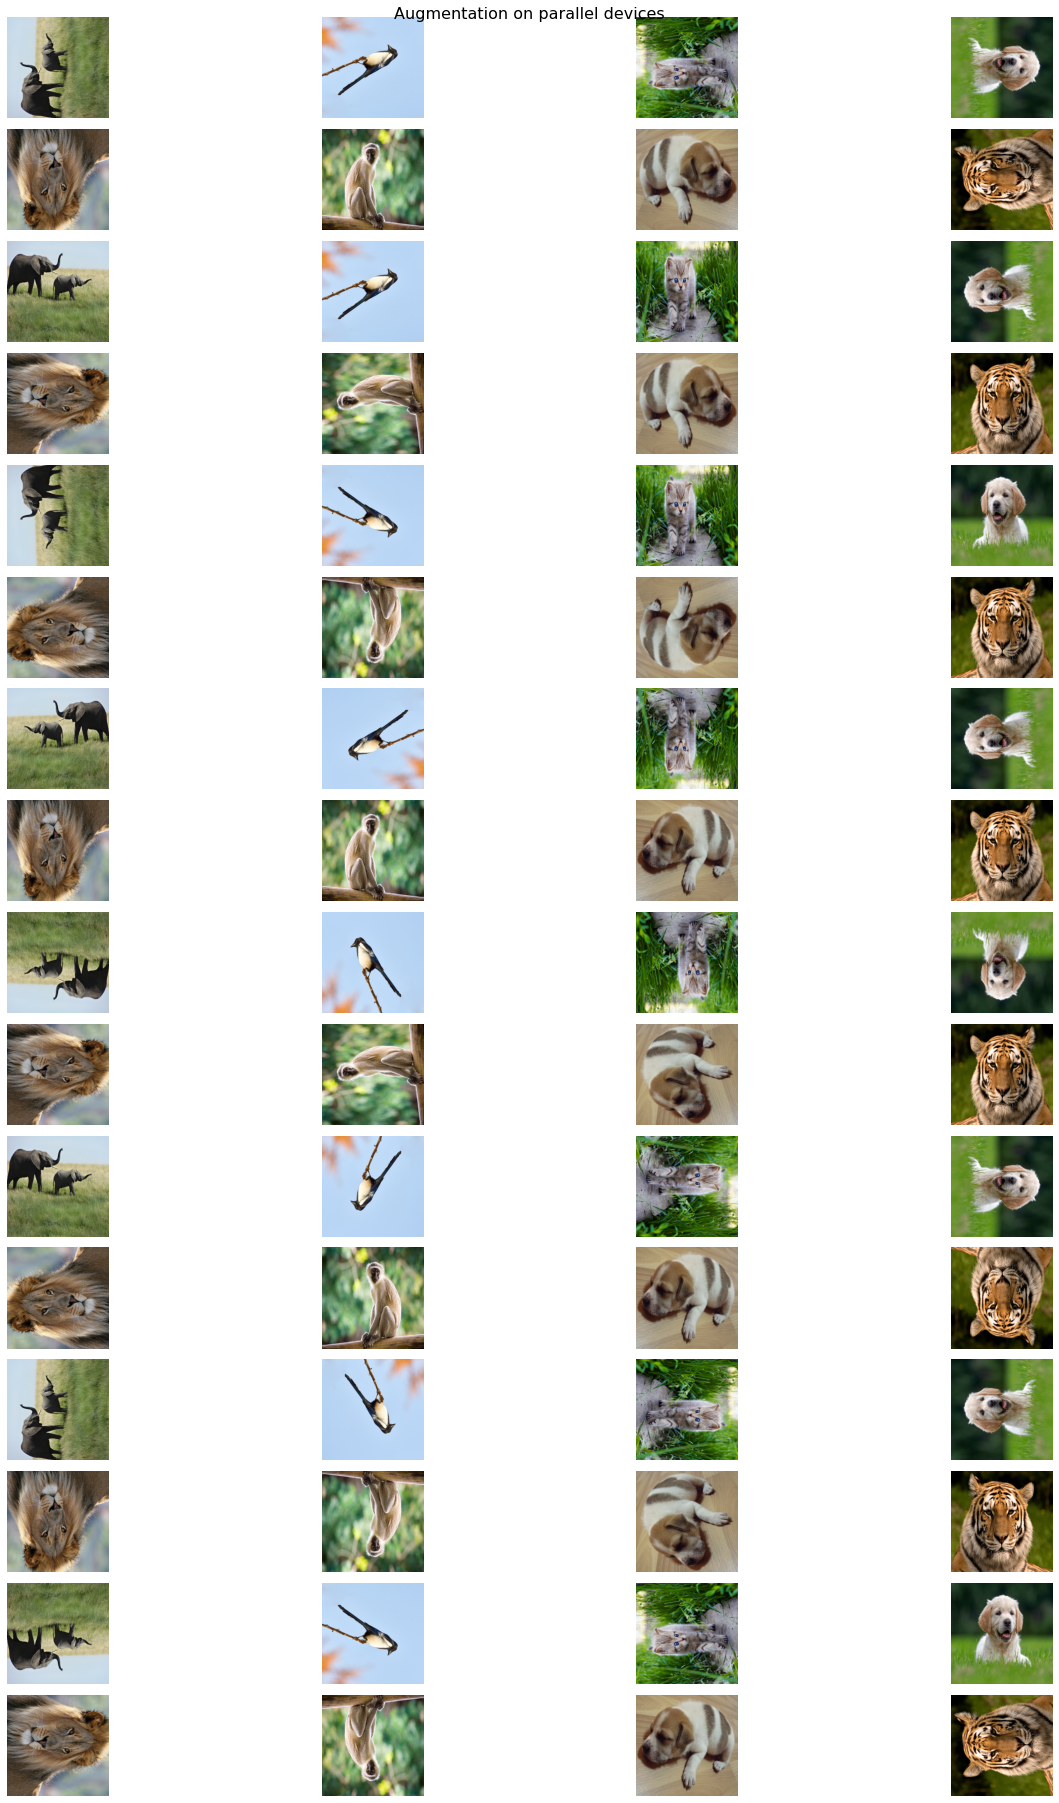

In [24]:
# Augment images parallely on multiple devices
pmapped_augment_images = pmap(augment_images, in_axes=(0, 0))

# We will run it more than once
for i in range(3):
    print("Call: ", i + 1, end=" => ")
    start_time = time.time()
    augmented_parallel = pmapped_augment_images(big_batch_images, big_batch_keys)
    print(f"Time taken to generate augmentations: {time.time()-start_time:.2f}")
    

# Plot the augmenetd images
augmented_parallel = augmented_parallel.reshape(64, 800, 800, 3)
plot_images(augmented_parallel,
            batch_size=64,
            title="Augmentation on parallel devices",
            figsize=(20, 25)
           )

Not only did we auto-vectorize the code, but we also made it run on multiple devices, **without making any major changes to the code**. 

<a href="https://emoji.gg/emoji/MindBlown"><img src="https://emoji.gg/assets/emoji/MindBlown.png" width="64px" height="64px" alt="MindBlown" align="center"></a>


A few things that you should note:

1. You can write code that works on a single example, vectorize it using `vmap` to run it on a batch, and you can run the same code on multiple devices using `pmap`
2. The philosophy behind vmap is: **Write for a single example, run it for a batch**
3. Notice the use of `seed` in the code. Because the random sequence is guaranteed to be the same, it is easy to debug the whole thing end-to-end
4. Once you get used to the mental model of `vmap` and `pmap`, there is no turning back as you have witnessed how powerful these two transformations are


That's it for Part8! Only a few more fundamental concepts remaining, and we will soon dive into the `NNs in JAX` part.
I hope you enjoyed the tutorial. I am also pretty sure that by now you are convinced that `vmap` and `pmap` are superpowers to have

# References

1. https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html
2. https://github.com/deepmind/dm_pix/
3. http://matpalm.com/blog/crazy_large_batch_sizes/